In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

from pypvcell.solarcell import SQCell,MJCell,DBCell
from pypvcell.illumination import Illumination
from pypvcell.photocurrent import gen_step_qe

/Users/kanhua/Dropbox/Programming/python_distribution_try/pypvcell_p3_lw/lib/python3.5/site-packages/matplotlib/cbook.py:128: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the matplotlib toolkit finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
input_ill=Illumination("AM1.5g")

Text(0,0.5,'efficiency')

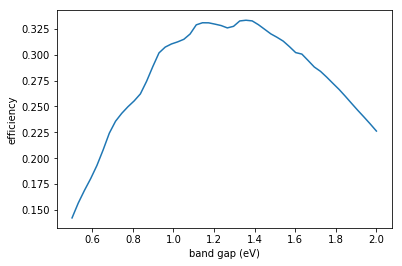

In [3]:
eg_array = np.linspace(0.5, 2.0)
eta_array_air_semi_class=[]
for eg in eg_array:
    sq_cell = SQCell(eg=eg, cell_T=293, n_c=1, n_s=1)
    sq_cell.set_input_spectrum(input_spectrum=input_ill)

    eta_array_air_semi_class.append(sq_cell.get_eta())

plt.plot(eg_array, eta_array_air_semi_class, label="nc=1,ns=1 (class)")
plt.xlabel("band gap (eV)")
plt.ylabel("efficiency")

## Calculate triple-junction cell with Germanium substrate

In [4]:
def get_3j_eta(conc_ill):
    top_eg=np.linspace(1.5,2.2,num=10) # Set up range of top cell band gaps
    mid_eg=np.linspace(0.9,1.4,num=50)# Set up range of top cell band gaps

    eta=np.zeros((10,50)) # Initialize an array for storing efficiencies

    ge_cell=SQCell(eg=0.67,cell_T=293)
    for i,teg in enumerate(top_eg):
        for j,beg in enumerate(mid_eg):
            tc=SQCell(eg=teg,cell_T=293) # Set up top cell
            bc=SQCell(eg=beg,cell_T=293) # Set up bottom cell
            mj=MJCell([tc, bc,ge_cell]) # Make multijunction cell by "streaming" the 1J cells
            mj.set_input_spectrum(conc_ill) # Set up the illumination
            eta[i,j]=mj.get_eta() # Store the calculated efficiency in an array
    return top_eg,mid_eg,eta

In [5]:
ill=Illumination("AM1.5d",concentration=240)
top_eg,mid_eg,eta=get_3j_eta(ill)

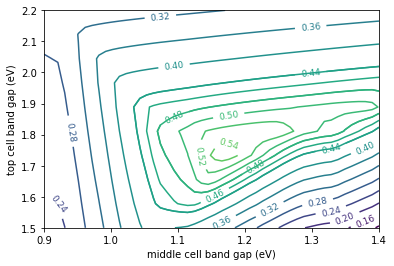

In [6]:
levels=np.unique(np.concatenate((np.arange(0.12,0.7,step=0.04),[0.44,0.46,0.48,0.50,0.54,0.56])))
cs=plt.contour(mid_eg,top_eg,eta,levels)
plt.clabel(cs,levels, fontsize=9, inline=1,fmt="%.2f")
plt.xlabel("middle cell band gap (eV)")
plt.ylabel("top cell band gap (eV)")
plt.savefig("3J_2d_240suns.pdf")

In [7]:
tc=SQCell(eg=1.87,cell_T=293) # Set up top cell
bc=SQCell(eg=1.42,cell_T=293) # Set up bottom cell
ge_cell=SQCell(eg=0.67,cell_T=293)
mj=MJCell([tc, bc,ge_cell]) # Make multijunction cell by "streaming" the 1J cells
mj.set_input_spectrum(ill)
print(mj.get_eta())

0.462042258631


## Compare Table II. of the EtaOpt paper
Condition: AM1.5d, Eg=1.13eV, T=300K

In [8]:
# The AM1.5d spectrum has to be normalized to 1000 W/m^2
input_ill=Illumination("AM1.5d",concentration=1000/918)
sq_cell = SQCell(eg=1.13, cell_T=293, n_c=3.5, n_s=1)
sq_cell.set_input_spectrum(input_spectrum=input_ill)
sq_cell.get_eta()

0.30992153594167304

Condition: 1.84/1.16/0.69

In [9]:
ill=Illumination("AM1.5d",concentration=462000*1000/918)
mj=MJCell([SQCell(eg=1.84,cell_T=293,n_c=1,n_s=1),
          SQCell(eg=1.16,cell_T=293,n_c=1,n_s=1),
          SQCell(eg=0.69,cell_T=293,n_c=1,n_s=1)])
mj.set_input_spectrum(input_spectrum=ill)
mj.get_eta()

0.63824158803071163

The result does not seemt to match very well (against 67%). Something goes wrong with the numerical calculation at large concentration.

(3, 4)

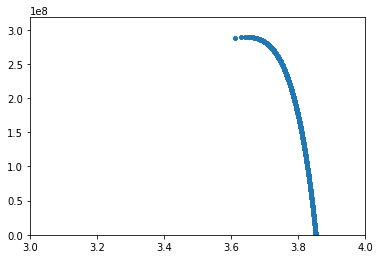

In [10]:
v,i=mj.get_iv()
plt.plot(v,-v*i,'.')
plt.ylim([0,np.max(-v*i)*1.1])
plt.xlim([3,4])

Check mechanical stack mode

In [11]:
ill=Illumination("AM1.5d",concentration=1000000)
mj=MJCell([SQCell(eg=1.84,cell_T=293,n_c=3.6,n_s=3.6),
          SQCell(eg=1.16,cell_T=293,n_c=3.6,n_s=3.6),
          SQCell(eg=0.71,cell_T=293,n_c=3.6,n_s=3.6)],connect='2T')
mj.set_input_spectrum(input_spectrum=ill)
mj.get_eta()

0.61491535160963973

## Check X/1.1eV
Find the optimal band gap on silicon subcell

In [12]:
input_ill=Illumination("AM1.5g",concentration=1)
top_eg=np.linspace(1.6,2,num=100) # Set up range of top cell band gaps

eta=np.zeros(100) # Initialize an array for storing efficiencies
jsc_ratio=np.zeros_like(eta)
si_cell=SQCell(eg=1.12,cell_T=293,n_c=3.5,n_s=1)
for i,teg in enumerate(top_eg):
    #qe=gen_step_qe(teg,1)
    #tc=DBCell(qe,rad_eta=1,T=293,n_c=3.5,n_s=1) # Set up top cell
    tc=SQCell(teg,cell_T=293)
    mj=MJCell([tc, si_cell]) # Make multijunction cell by "streaming" the 1J cells
    mj.set_input_spectrum(input_ill) # Set up the illumination
    eta[i]=mj.get_eta() # Store the calculated efficiency in an array
    jsc_a=mj.get_subcell_jsc()
    jsc_ratio[i]=jsc_a[0]/jsc_a[1]
    #print(jsc_a)

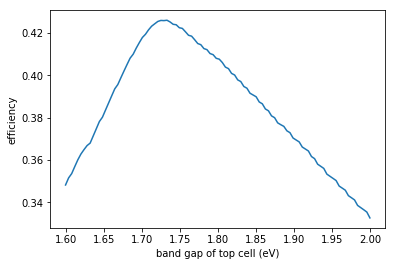

In [13]:
plt.plot(top_eg,eta)
plt.xlabel("band gap of top cell (eV)")
plt.ylabel("efficiency")
plt.savefig("sj_on_si.pdf")

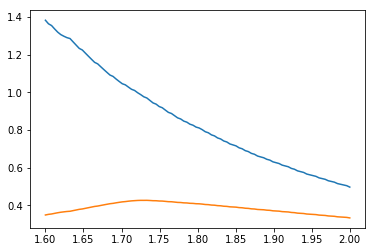

In [14]:
plt.plot(top_eg,jsc_ratio)
plt.plot(top_eg,eta)

Optimal top cell band gap

In [15]:
top_eg[np.argmax(eta)]

1.7333333333333334

maximum efficiency

In [16]:
np.max(eta)

0.42598872312796932

In [17]:
x,y=Illumination("AM1.5g").get_spectrum('eV')

(1.65, 1.75)

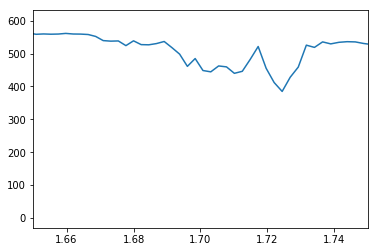

In [18]:
plt.plot(x,y)
plt.xlim([1.65,1.75])

In [19]:
input_ill=Illumination("AM1.5g",concentration=1)
top_eg=np.linspace(1.6,2,num=100) # Set up range of top cell band gaps

eta=np.zeros(100) # Initialize an array for storing efficiencies
jsc_ratio=np.zeros_like(eta)
si_cell=SQCell(eg=1.12,cell_T=293,n_c=3.5,n_s=1)

#qe=gen_step_qe(teg,1)
#tc=DBCell(qe,rad_eta=1,T=293,n_c=3.5,n_s=1) # Set up top cell
tc=SQCell(1.70,cell_T=293)
mj=MJCell([tc, si_cell]) # Make multijunction cell by "streaming" the 1J cells
mj.set_input_spectrum(input_ill) # Set up the illumination
eta=mj.get_eta(verbose=1) # Store the calculated efficiency in an array
print(eta)

Jmp :-210.022811855
Vmp :1.98576463179
max power:417.055871652
Jmp :-210.028812287
Vmp :1.98570974584
max power:417.056259464
Jmp :-210.028812287
Vmp :1.98570974584
max power:417.056259464
Jmp :-210.028812287
Vmp :1.98570974584
max power:417.056259464
Jmp :-210.028812287
Vmp :1.98570974584
max power:417.056259464
Jmp :-210.028812287
Vmp :1.98570974584
max power:417.056259464
Jmp :-210.028812287
Vmp :1.98570974584
max power:417.056259464
Jmp :-210.028812287
Vmp :1.98570974584
max power:417.056259464
0.416901732514


In [20]:
ill=Illumination("AM1.5do")

In [21]:
ill.total_power()

767.1738049999999

In [22]:
ill=ill*1000/767

In [23]:
ill2=Illumination("AM1.5g")*1000/918

In [24]:
a=ill.get_spectrum('nm')
b=ill2.get_spectrum('nm')

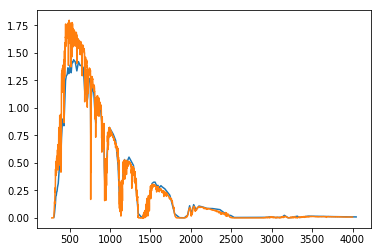

In [26]:
plt.plot(*a)
plt.plot(*b)